### Extract Deep Convolutional Activation Feature for Yelp Image Classification Challenge

In [1]:
##only run this when you need to run pyspark on graphlab
#!export SPARK_HOME="/Users/XXX/spark-1.6.0-bin-hadoop2.6/bin"
#!export PYTHONPATH=$SPARK_HOME/python/:$SPARK_HOME/python/lib/py4j-0.9-src.zip:$PYTHONPATH
#!which python

In [138]:
#import findspark
#findspark.init()
import graphlab as gl
import pandas as pd
import numpy as np
import glob
import random
#import pyspark
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Data preparation

You can run full training set with a GPU instance but I used a spot instance so I did feature extraction in a batch mode

In [205]:
# divide 230K image files into 10 lists !!!! only run this chunk one time because it is time consuming
path = glob.glob('kaggle_yelp/test_photos/*.jpg')
lst_file = [file for file in path]

def partition(lst):
    random.shuffle(lst)
    division = len(lst) / float(10)
    return [lst[int(round(division * i)): int(round(division * (i + 1)))] for i in range(10) ]

lst_image = partition(lst_file)
len(lst_image)
    

10

In [207]:
# copy image file in each of the list to a new folder !!!! only run this one time
import shutil
root_path = 'kaggle_yelp'

def copy_image(root_path):
    for i in range(len(lst_image)):
        folder = "test_" + str(i)
        os.mkdir(os.path.join(root_path,folder))
        
        for pic_file in lst_image[i]:
            shutil.copy(pic_file, os.path.join(root_path,folder))
        
        i += 1
    
copy_image(root_path)


### Feature Extraction

We used Alexnet which is a pre-trained converlutional neural network trained from ImageNet, we extracted features from the last full connection layer before the classification to represent the features of our image. For more information of using a pre-trained neural network, please refer the paper: DeCAF: A Deep Convolutional Activation Feature for Generic Visual Recognition

In [139]:
gl.deeplearning.get_builtin_neuralnet('imagenet')


### network layers ###
layer[0]: ConvolutionLayer
  init_random = gaussian
  padding = 0
  stride = 4
  num_channels = 96
  num_groups = 1
  kernel_size = 11
layer[1]: RectifiedLinearLayer
layer[2]: MaxPoolingLayer
  padding = 0
  stride = 2
  kernel_size = 3
layer[3]: LocalResponseNormalizationLayer
  alpha = 0.001
  beta = 0.75
  knorm = 1
  local_size = 5
layer[4]: ConvolutionLayer
  init_random = gaussian
  padding = 2
  stride = 1
  num_channels = 256
  num_groups = 2
  kernel_size = 5
layer[5]: RectifiedLinearLayer
layer[6]: MaxPoolingLayer
  padding = 0
  stride = 2
  kernel_size = 3
layer[7]: LocalResponseNormalizationLayer
  alpha = 0.001
  beta = 0.75
  knorm = 1
  local_size = 5
layer[8]: ConvolutionLayer
  init_random = gaussian
  padding = 1
  stride = 1
  num_channels = 384
  num_groups = 1
  kernel_size = 3
layer[9]: RectifiedLinearLayer
layer[10]: ConvolutionLayer
  init_random = gaussian
  padding = 1
  stride = 1
  num_channels = 384
  num_groups = 2
  kernel_size = 

In [ ]:
# extract deep feature for the trainning set and store them in S3, this was running on EC2 g2.2XLarge instance
gl.product_key.set_product_key('***')
gl.product_key.get_product_key()
gl.aws.set_credentials('***', '**')
path = 's3://awesomedata/yelp/'

def extract_feature(path):
    pic_dir = glob.glob('train_*')
    
    model = gl.toolkits.feature_engineering.DeepFeatureExtractor(features = 'image',
                                                                 model='auto', 
                                                                 output_column_prefix='features')
    i = 0

    for folder in pic_dir:
        print folder
   
        image_load = gl.image_analysis.load_images(folder, "auto", with_path=True, recursive=True)
        image_load['image'] = gl.image_analysis.resize(image_load['image'], 256, 256, 3)
    
        extract_id = lambda x: int(re.match('.*/([0-9]+).jpg', x).group(1))
        train_ids = map(extract_id, image_load['path'])
    
        image_load['path'] = train_ids
        image_load.rename({'path': 'pic_id'})
    
    
        image_load = model.fit_transform(image_load)
        image_feature = image_load['pic_id', 'features.image']
        image_feature.save(path + 'train_' + str(i) )
    
        i += 1

In [ ]:
# combining all subset of features into one SFrame, reading from S3
folder_name = ['train_' + str(i) for i in range(10)]

def combine_feature(folder_lst):
    traindf = gl.SFrame(path + 'train_0')
    
    for dir in folder_lst[1:]:
        traindf = traindf.append(gl.SFrame(path + dir))
    
    return traindf

train = combine_feature(folder_name)


(0, 12)

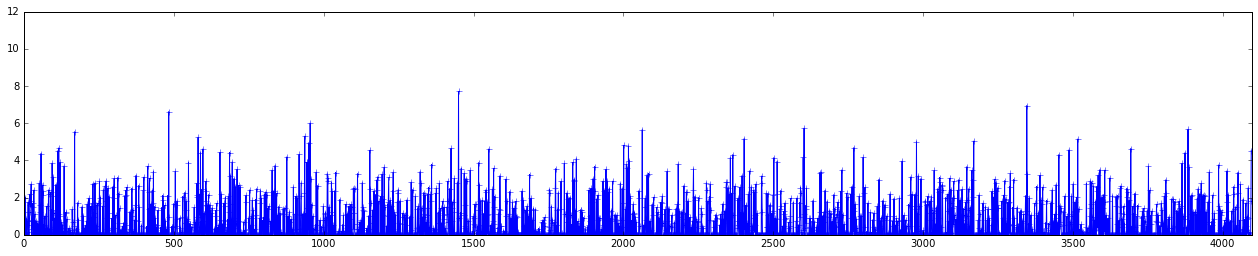

In [46]:
# the plot below shows feature difference bwteen images that are similar
plt.figure(figsize=(22,4))
da = list(train[train['pic_id'] == 375743]['features.image'][0])
db = list(train[train['pic_id'] == 244195]['features.image'][0])
diff = [abs(vb-va) for vb,va in zip(db,da)]
plt.plot(range(4096), diff, marker='+', color='b')
plt.xlim((0, 4096))
plt.ylim((0,12))

### Assign labels to pictures

In [2]:
# the following steps are for joining pic_id with labels
pic_biz = gl.SFrame('./Kaggle_Yelp/train_photo_to_biz_ids.csv')

In [3]:
biz_label = gl.SFrame('./Kaggle_Yelp/train.csv')

In [23]:
pic_biz_label = biz_label.join(pic_biz, on='business_id')

In [24]:
pic_biz_label

business_id,labels,photo_id
3034,3 8,204149
2805,1 2 3 5 6 7,52779
485,1 2 3 4 5 6 7,278973
485,1 2 3 4 5 6 7,195284
485,1 2 3 4 5 6 7,19992
485,1 2 3 4 5 6 7,80748
1783,1 2 3 5 6 7,444996
35,1 2 5 6 8,200285
35,1 2 5 6 8,90572
1313,3 6 8,27565


In [25]:
pic_label = pic_biz_label['photo_id', 'labels']
pic_label

photo_id,labels
204149,3 8
52779,1 2 3 5 6 7
278973,1 2 3 4 5 6 7
195284,1 2 3 4 5 6 7
19992,1 2 3 4 5 6 7
80748,1 2 3 4 5 6 7
444996,1 2 3 5 6 7
200285,1 2 5 6 8
90572,1 2 5 6 8
27565,3 6 8


In [26]:
train = pic_label.join(train_df, on={'photo_id':'pic_id'})

In [27]:
train

photo_id,labels,features.image
103689,1 2 3 4 5 6 7,"[0.170720815659,0.239150226116, 0.0, ..."
448995,0 5 8,"[0.0, 0.0, 0.0, 0.0,1.94480085373, 0.0, 0.0, ..."
396884,0 3 8,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
210835,1 2 3 4 5 6 7,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."
429621,5 8,"[0.0, 0.0, 0.0, 0.0, 0.0,3.75866699219, 0.0, 0.0, ..."
470306,0 2 6 8,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
414570,1 2 4 5 6 7 8,"[0.0, 0.0,0.600430548191, 0.0, ..."
310517,0 1 2 5 6 8,"[0.0, 0.0,0.241091310978, 0.0, ..."
79185,1 2 3 4 5 6 7,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."
441942,2 8,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
train['labels'] = train['labels'].apply(lambda x: x.split(" "))
train['photo_id', 'labels'].save('train_pic_label_all.csv', format='csv')

In [35]:
def map_label(x):
    label = dict()
    
    for item in x:
        label[item] = 1
    return label

train['labels'] = train['labels'].apply(lambda x: map_label(x))
train = train.unpack('labels')
train.remove_column('labels.')

train.rename ({"photo_id": "pic_id", 
                 "features.image": "features", 
                 "labels.0": "good_for_lunch", 
                 "labels.1": "good_for_dinner",
                 "labels.2": "takes_reservations",
                 "labels.3": "outdoor_seating", 
                 "labels.4": "restaurant_is_expensive",
                 "labels.5": "has_alcohol", 
                 "labels.6": "has_table_service", 
                 "labels.7": "ambience_is_classy", 
                 "labels.8": "good_for_kids"})

for name in train.column_names()[2:11]:
    train = train.fillna(name, 0)

In [4]:
train.save('traindf')

### Build binary classifier on each label, train the classifier on graphlab ec2 cluster

In [70]:
# load the feature SFrame
train = gl.SFrame('traindf')

In [120]:
ec2config = gl.deploy.Ec2Config()

In [121]:
ec2 = gl.deploy.ec2_cluster.create(name='yelp',
                                   s3_path=path,
                                   ec2_config=ec2config,
                                   num_hosts=4)

[INFO] Launching an m3.xlarge instance in the us-west-2b availability zone, with id: i-a689227e. You will be responsible for the cost of this instance.
[INFO] 3 additional hosts will be launched by i-a689227e
[INFO] Waiting for i-a689227e to start up.
[INFO] Deleting keys: []


In [124]:
c = gl.deploy.ec2_cluster.load(path)
job = gl.deploy.job.create(get_classifier, environment=c, train = train)